# A comparison of toroidal meniscus models with different profile shapes

## Introduction

In the study [Capillary Hysteresis in Neutrally Wettable Fibrous Media: A Pore Network Study of a Fuel Cell Electrode](http://link.springer.com/10.1007/s11242-017-0973-2) percolation in fibrous media was simulated using a meniscus model that assumed the contrictions between fibers are similar to a toroid:

![](https://media.giphy.com/media/AIbz7mpqxgc5a/giphy.gif)

This model was first proposed by Purcell and treats the inner solid profile as a circle. As the fluid invades through the center of the torus the meniscus is pinned to the surface and the "effective" contact angle becomes influenced by the converging diverging geometry and is a function of the filling angle $\alpha$. The shape of the meniscus as the invading phase moves upwards through the torus with key model parameters is shown below.

![](https://i.imgur.com/b2der2w.png)

Different intrinsic contact angles through invading phase are shown above: (a) 60$^\circ$, (b) 90$^\circ$ and (c) 120$^\circ$. All scenarios clearly show an inflection of the meniscus curvature signifying a switch in the sign of the capillary pressure from negative to positive. This inflection is predicted to occur for all contact angles by the model with varying filling angle. The capillary pressure can be shown to be:

$P_C = -2\sigma cos(\theta-\alpha))/(r+R(1-cos(\alpha))$

A consequence of the circular solid profile is that all fluid behaves as non-wetting fluid because $\alpha$ can range from -90$^\circ$ to 90$^\circ$ degrees and so even if $\theta$ is 0 then the meniscus is still pinned at zero capillary pressure at the very furthest part of the throat where the $\alpha$ is 90$^\circ$

Considering other shapes of solid profile this situation can be avoided. It will be shown by reformulating the Purcell model in a more general way that allows for a flexible defintion of the solid profile that filling angle can be limited to values below 90 and allow for spontaneous imbibition (percolation threshold below zero) of highly wetting fluids.

## Set up
We will set up a trivially small network with one throat to demonstrate the use of the meniscus model. Here we do the imports and define a few functions for plotting.

In [1]:
#from sympy import init_session, init_printing
#init_session(quiet=True)
#init_printing()
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as syp
from sympy import lambdify, symbols
from sympy import atan as sym_atan
from sympy import cos as sym_cos
from sympy import sin as sym_sin
from sympy import sqrt as sym_sqrt
from sympy import pi as sym_pi
from ipywidgets import interact, fixed
from IPython.display import display

matplotlib.rcParams['figure.figsize'] = (5, 5)

In [2]:
theta = 30
fiberRad = 5e-5
throatRad = 5e-5
max_bulge = 6e-5

Now we define our two pore network and add the meniscus model in several modes: 'max' returns the maximum pressure experienced by the meniscus as it transitions through the throat, i.e. the burst entry pressure. 'touch' is the pressure at which the meniscus has protruded past the throat center a distance defined by the 'touch_length' dictionary key. In network simulations this could be set to the pore_diameter. Finally the 'men' mode accepts a target_Pc parameter and returns all the mensicus information required for assessing cooperative filling or plotting.

In [3]:
import openpnm as op
import openpnm.models.physics as pm
net = op.network.Cubic(shape=[2, 1, 1], spacing=5e-5)
geo = op.geometry.StickAndBall(network=net,
                               pores=net.pores(),
                               throats=net.throats())
phase = op.phases.Water(network=net)
phase['pore.contact_angle'] = theta
phys = op.physics.Standard(network=net,
                           phase=phase,
                           geometry=geo)
geo['throat.diameter'] = throatRad*2
geo['throat.touch_length'] = max_bulge

We define a plotting function that uses the meniscus data:
$\alpha$ is filling angle as defined above,
$radius$ is the radius of curvature of the mensicus,
$center$ is the position of the centre of curvature relative to the throat center along the axis of the throat,
$\gamma$ is the angle between the throat axis and the line joining the meniscus center and meniscus contact point.

In [4]:
def plot_meniscus(target_Pc, meniscus_model=None):
    phys.add_model(propname='throat.meniscus',
                   model=meniscus_model,
                   mode='men',
                   r_toroid=fiberRad,
                   target_Pc=target_Pc)
    throatRad = geo['throat.diameter'][0]/2
    theta = np.deg2rad(phys['pore.contact_angle'][0])
    x_points = np.arange(-0.99, 0.99, 0.01)*fiberRad
    fig, ax = plt.subplots()
    if meniscus_model.__name__ == 'purcell':
        # Parameters for plotting fibers
        x, R, rt, s, t = syp.symbols('x, R, rt, s, t')
        y = R*syp.sqrt(1- (x/R)**2)
        r = rt + (R-y)
        rx = syp.lambdify((x, R, rt), r, 'numpy')
        ax.plot(x_points, rx(x_points, fiberRad, throatRad), 'k-')
        ax.plot(x_points, -rx(x_points, fiberRad, throatRad), 'k-')
    elif meniscus_model.__name__ == 'sinusoidal':
        throat_a = throat_b = fiberRad
        x, a, b, rt, sigma, theta = syp.symbols('x, a, b, rt, sigma, theta')
        y = (sym_cos(np.pi*x/(2*a)))*b
        r = rt + (b-y)
        rx = lambdify((x, a, b, rt), r, 'numpy')
        ax.plot(x_points, rx(x_points, throat_a, throat_b, throatRad), 'k-')
        ax.plot(x_points, -rx(x_points, throat_a, throat_b, throatRad), 'k-')
    else:
        # General Ellipse
        x, a, b, rt, sigma, theta = syp.symbols('x, a, b, rt, sigma, theta')
        y = sym_sqrt(1 - (x/a)**2)*b
        r = rt + (b-y)
        rx = lambdify((x, a, b, rt), r, 'numpy')
        ax.plot(x_points, rx(x_points, phys['throat.scale_a'], phys['throat.scale_b'], throatRad), 'k-')
        ax.plot(x_points, -rx(x_points, t_a, t_b, throatRad), 'k-')
    men_data = {}
    men_data['alpha'] = phys['throat.meniscus.alpha']
    men_data['gamma'] = phys['throat.meniscus.gamma']
    men_data['radius'] = phys['throat.meniscus.radius']
    men_data['center'] = phys['throat.meniscus.center']
    arc_cen = men_data['center']
    arc_rad = men_data['radius']
    arc_angle = men_data['gamma']
    angles = np.linspace(-arc_angle, arc_angle, 100)
    arcx = arc_cen + arc_rad*np.cos(angles)
    arcy = arc_rad*np.sin(angles)
    ax.plot(arcx, arcy, 'b-')
    ax.axis('equal')
    ax.ticklabel_format(style='sci', axis='both', scilimits=(-6,-6))
    return ax

# Circular (Purcell)

In [5]:
circular_model = pm.meniscus.purcell

phys.add_model(propname='throat.max',
               model=circular_model,
               mode='max',
               r_toroid=fiberRad)
phys.add_model(propname='throat.touch',
               model=circular_model,
               mode='touch',
               r_toroid=fiberRad)
phys.add_model(propname='throat.meniscus',
               model=circular_model,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=1000)
touch_Pc = phys['throat.touch'][0]
print('Pressure at maximum bulge', np.around(touch_Pc, 0))
max_Pc_circle = phys['throat.max'][0]
print('Circular profile critical entry pressure', np.around(max_Pc_circle, 0))

Pressure at maximum bulge 439.0
Circular profile critical entry pressure 661.0


We can see that the touch_Pc calculated earlier, corresponds with the tip of the meniscus exceeding the max_bulge parameter. Try changing this and re-running to see what happens.

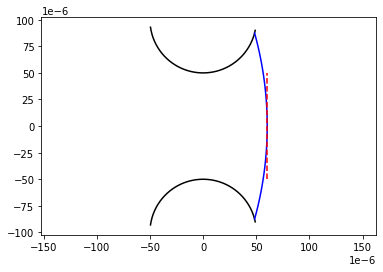

In [6]:
ax = plot_meniscus(target_Pc=touch_Pc, meniscus_model=circular_model)
ax.plot([max_bulge, max_bulge], [-throatRad, throatRad], 'r--')

We can interact with the mensicus model by changing the target_Pc parameter.

In [7]:
interact(plot_meniscus, target_Pc=(-2000, max_Pc_circle, 1), meniscus_model=fixed(circular_model))

interactive(children=(FloatSlider(value=-670.0, description='target_Pc', max=660.5643308442607, min=-2000.0, s…

<function __main__.plot_meniscus(target_Pc, meniscus_model=None)>

Here we can see that the critical entry pressure for the circular profile is positive, even though the intrinsic contact angle is highly non-wetting

# Sinusoidal

Now we can start to compare the different meniscus models:

In [8]:
sinusoidal_model = pm.meniscus.sinusoidal

In [9]:
display(sinusoidal_model)

<function openpnm.models.physics.meniscus.sinusoidal(target, mode='max', target_Pc=None, num_points=1000.0, r_toroid=5e-06, throat_diameter='throat.diameter', pore_diameter='pore.diameter', touch_length='throat.touch_length', surface_tension='pore.surface_tension', contact_angle='pore.contact_angle')>

In [10]:
phys.add_model(propname='throat.meniscus',
               model=sinusoidal_model,
               mode='men',
               r_toroid=fiberRad,
               target_Pc=1000)

The equation for the solid sinusoidal profile is:

In [11]:
x, a, b, rt, sigma, theta = syp.symbols('x, a, b, rt, sigma, theta')
y = (sym_cos(sym_pi*x/(2*a)))*b
r = rt + b-y
r

-b*cos(pi*x/(2*a)) + b + rt

In [12]:
# Derivative of profile
rprime = r.diff(x)
rprime

pi*b*sin(pi*x/(2*a))/(2*a)

In [13]:
# Filling angle
alpha = sym_atan(rprime)
alpha

atan(pi*b*sin(pi*x/(2*a))/(2*a))

In [14]:
# angle between y axis, meniscus center and meniscus contact point
eta = sym_pi - (theta + alpha)
eta

-theta - atan(pi*b*sin(pi*x/(2*a))/(2*a)) + pi

In [15]:
# angle between x axis, meniscus center and meniscus contact point
gamma = sym_pi/2 - eta
gamma

theta + atan(pi*b*sin(pi*x/(2*a))/(2*a)) - pi/2

In [16]:
# Radius of curvature of meniscus
rm = r/sym_cos(eta)
rm

-(-b*cos(pi*x/(2*a)) + b + rt)/cos(theta + atan(pi*b*sin(pi*x/(2*a))/(2*a)))

In [17]:
# distance along x-axis from center of curvature to meniscus contact point
d = rm*sym_sin(eta)
d

-(-b*cos(pi*x/(2*a)) + b + rt)*sin(theta + atan(pi*b*sin(pi*x/(2*a))/(2*a)))/cos(theta + atan(pi*b*sin(pi*x/(2*a))/(2*a)))

In [18]:
# Capillary Pressure
p = 2*sigma/rm
p

-2*sigma*cos(theta + atan(pi*b*sin(pi*x/(2*a))/(2*a)))/(-b*cos(pi*x/(2*a)) + b + rt)

In [19]:
phys.add_model(propname='throat.max',
               model=sinusoidal_model,
               mode='max',
               r_toroid=fiberRad)
phys.add_model(propname='throat.touch',
               model=sinusoidal_model,
               mode='touch',
               r_toroid=fiberRad)
max_Pc_sin = phys['throat.max'][0]
print(max_Pc_sin)

-62.44809550871156


In [20]:
interact(plot_meniscus, target_Pc=(-2000, max_Pc_sin, 1), meniscus_model=fixed(sinusoidal_model))

interactive(children=(FloatSlider(value=-1032.0, description='target_Pc', max=-62.44809550871156, min=-2000.0,…

<function __main__.plot_meniscus(target_Pc, meniscus_model=None)>

Now the crtical entry pressure is negative signifying that spontaneous imbibition will occur

# General Elliptical

Similarly we can define an elliptical profile and use the same method to determine the capillary pressure:

In [21]:
y = sym_sqrt(1 - (x/a)**2)*b
y

b*sqrt(1 - x**2/a**2)

In-fact this is the model that OpenPNM uses for Purcell as well with a = b = fiber radius

In [22]:
# Scale ellipse in x direction
phys['throat.scale_a'] = fiberRad
# Scale ellipse in y direction
phys['throat.scale_b'] = 3.0*fiberRad
elliptical_model = pm.meniscus.general_toroidal
phys.add_model(propname='throat.max',
               model=elliptical_model,
               mode='max')
max_Pc_ellipse = phys['throat.max'][0]
print(max_Pc_ellipse)

380.67168089638767


In [23]:
interact(plot_meniscus, target_Pc=(-2000, max_Pc_ellipse, 1), meniscus_model=fixed(sinusoidal_model))

interactive(children=(FloatSlider(value=-810.0, description='target_Pc', max=380.67168089638767, min=-2000.0, …

<function __main__.plot_meniscus(target_Pc, meniscus_model=None)>

The two scale factors can now be used to determine a wide range of capillary behaviours with one general model.